# Second-order model

## Dynamics of the Heater/Sensor System

The previous results are not yet fully satisfactory. We're still missing the initial 'lag' in response of the measured temperature. 

For this model we consider the possibility that the heater and sensor may not be at the same temperature. To account for this possibility, we introduce $T_{H,1}$ to denote the temperature of heater one and $T_{S,1}$ to denote the temperature of the corresponding sensor. We'll further assume the sensor exchanges heat only with the heater, and heat transfer to the surroundings is through the heat sink attached to the heater.

This motivates a model

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}

where $C^H_p$ and $C^S_p$ are the heat capacities of the heater and sensor, respectively, and $U_b$ is a new heat transfer coefficient characterizing the exchange of heat between the heater and sensor.

\begin{align}
\frac{dT_{H,1}}{dt} & = -\frac{U_a+U_b}{C^H_p}T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1}) 
\end{align}

Where measured temperature, that is, the temperature recorded by the Arduino, $T_1$ is given by

$$T_1 = T_{S,1}$$

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import  pandas as pd

# known parameters
T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units
U1 = 50                # steady state value of u1 (percent)

# read data file. 
data_file = "https://raw.githubusercontent.com/jckantor/cbe30338-book/main/notebooks/data/tclab-data-example.csv"
data = pd.read_csv(data_file).set_index("Time")[1:]
t_expt = data.index
T1 = data['T1'].values

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C

def model_energy_second_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub = param

    # model solution
    def deriv(t, y):
        T1H, T1S = y
        dT1H = (-(Ua + Ub)*T1H + Ub*T1S + alpha*P1*U1 + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        return [dT1H, dT1S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb, T_amb], t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
        
    return pred["T1"] - data["T1"]
    
model_energy_second_order([CpH, CpS, Ua, Ub], plot=False)

Time
1.00     -0.543000
2.01     -0.535029
3.01     -0.512148
4.00     -0.475868
5.00     -0.427309
            ...   
796.00   -5.335340
797.01   -5.173834
798.01   -5.431413
799.00   -5.334092
800.01   -5.720880
Name: T1, Length: 800, dtype: float64

### Best fit

In [12]:
from scipy.optimize import least_squares

results = least_squares(model_energy_second_order,  [CpH, CpS, Ua, Ub])
CpH, CpS, Ua, Ub = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub}")
model_energy_second_order(results.x, False)

CpH = 2.2888335491295524,  CpS = 2.3039928054444236,   Ua = 0.043567404080568334,  Ub = 0.03740603797495637


Time
1.00     -0.543000
2.01     -0.537311
3.01     -0.520849
4.00     -0.494547
5.00     -0.458562
            ...   
796.00   -0.722437
797.01   -0.560728
798.01   -0.818011
799.00   -0.720289
800.01   -1.106541
Name: T1, Length: 800, dtype: float64

## Fourth-Order Multi-Input Multi-Output Model

### Model derivation

\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + U_c(T_{H,2}-T_{H,1})  + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{S,2} - T_{H,2}) + U_c(T_{H,1}-T_{H,2}) + \alpha P_2 u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_b(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

### Standard form

\begin{align}
\frac{dT_{H,1}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,1} + \frac{U_b}{C^H_p}T_{S,1} + \frac{U_c}{C^H_p}T_{H,2}  + \frac{\alpha P_1}{C^H_p}u_1 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1})  \\
\frac{dT_{H,2}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})T_{H,2} + \frac{U_b}{C^H_p}T_{S,2} + \frac{U_c}{C^H_p}T_{H,1}  + \frac{\alpha P_2}{C^H_p}u_2 + \frac{U_a}{C^H_p}T_{amb}\\
\frac{dT_{S,2}}{dt} & = \frac{U_b}{C^S_p}(T_{H,2} - T_{S,2}) 
\end{align}

where

\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}

array([ -0.221     ,   0.34640496,   0.76940428,   1.05824442,
         1.13171249,   1.24645305,   1.07316775,   0.81586616,
         0.48007917,  -0.13344645,  -0.48890253,  -0.70921588,
        -1.25124638,  -1.76745403,  -2.20823788,  -2.69742627,
        -3.14122854,  -3.52330422,  -4.01831601,  -4.40206324,
        -4.88886002,  -5.19721912,  -5.48385191,  -5.96815841,
        -6.40553965,  -6.57439776,  -6.70435903,  -6.9013846 ,
        -7.2455444 ,  -7.69003022,  -7.92579427,  -8.09662387,
        -8.30244458,  -8.28467125,  -8.45397113,  -8.44203263,
        -8.55229841,  -8.76329137,  -8.79264212,  -8.97090733,
        -9.05270848,  -9.21073629,  -9.11325468,  -9.42975647,
        -9.44638557,  -9.61415333,  -9.564619  ,  -9.87641255,
       -10.01102868,  -9.74099527,  -9.82511837,  -9.804095  ,
       -10.08438906, -10.11845575, -10.39033103, -10.67585924,
       -10.64774194, -10.64625393, -10.63882106, -10.84765596,
       -10.44699971,  -0.446     ,  -0.48503157,  -0.44

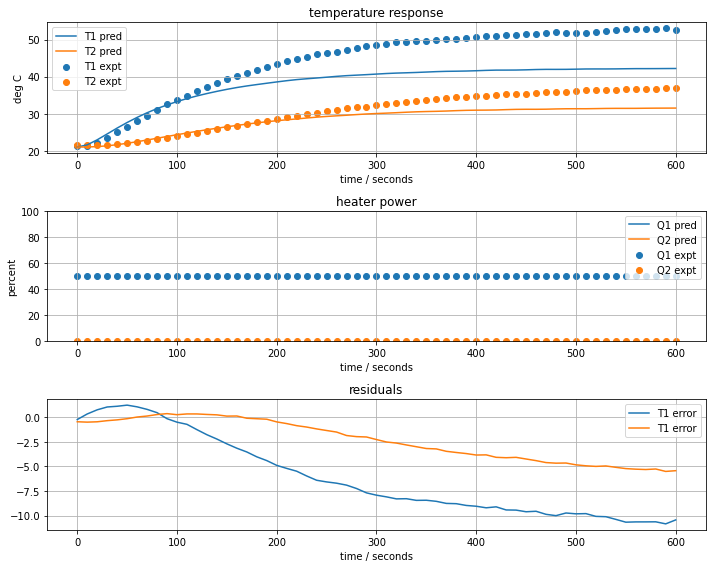

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# adjustable parameters
CpH = 5                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.05              # watts/deg C

def model_energy_fourth_order(param, plot=False):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  

    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*T1H + Ub*T1S + Uc*T2H + alpha*P1*u1(t) + Ua*T_amb)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*T2H + Ub*T2S + Uc*T1H + alpha*P2*u2(t) + Ua*T_amb)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T1"] = soln.y[1]
    pred["T2"] = soln.y[3]

    # plot solution
    if plot:
        ax = plot_data(expt, pred)
    
    err1 = np.array(pred["T1"] - expt["T1"])
    err2 = np.array(pred["T2"] - expt["T2"])
    
    return np.concatenate((err1, err2))
    
model_energy_fourth_order([CpH, CpS, Ua, Ub, Uc], plot=True)

CpH = 4.4642229433310705,  CpS = 0.8190620772014501,   Ua = 0.032226735496058236,  Ub = 0.01862452210295832,  Uc = 0.033554024370968105


array([-0.221     ,  0.10032875,  0.05752008, -0.00405231, -0.10773464,
        0.01920575,  0.02181627,  0.03268211,  0.05934022, -0.12621606,
       -0.02560712,  0.22155593,  0.1591108 ,  0.12013875,  0.14267453,
        0.09875163,  0.08540225,  0.13037096,  0.05135871,  0.04902892,
       -0.09703112, -0.09303583, -0.06500128, -0.20674525, -0.32566391,
       -0.22615469, -0.12616143, -0.08732116, -0.16917961, -0.37119119,
       -0.39871904, -0.38303497, -0.3863195 , -0.15266185, -0.13605994,
        0.01670928,  0.02122981, -0.05314745,  0.08779108,  0.06239935,
        0.09510954,  0.02842961,  0.244774  ,  0.09824684,  0.2274448 ,
        0.14545713,  0.23302579, -0.01549275, -0.04315274,  0.31607625,
        0.29086137,  0.36550651,  0.18295226,  0.25477598,  0.05819174,
       -0.19055652, -0.12624109, -0.06348875, -0.00238632, -0.16838589,
        0.27369513, -0.446     , -0.50119113, -0.51353834, -0.49453376,
       -0.52704126, -0.5249296 , -0.46191438, -0.43668769, -0.33

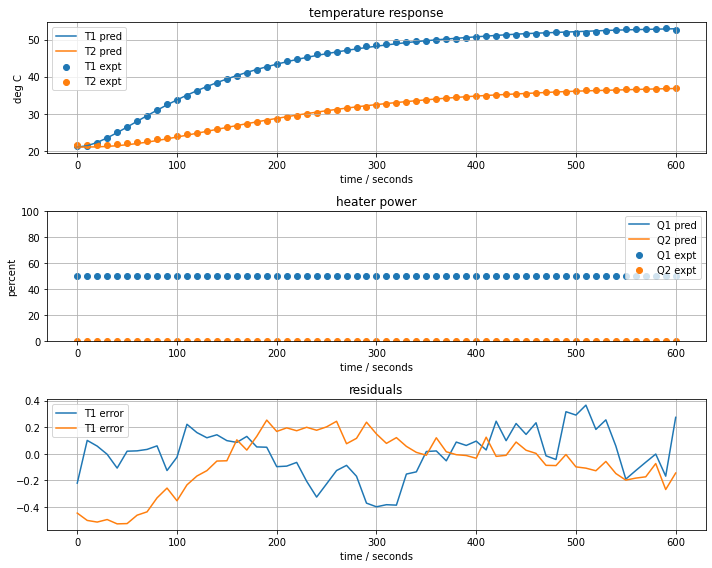

In [14]:
results = least_squares(model_energy_fourth_order,  [CpH, CpS, Ua, Ub, Uc])
CpH, CpS, Ua, Ub, Uc = results.x
print(f"CpH = {CpH},  CpS = {CpS},   Ua = {Ua},  Ub = {Ub},  Uc = {Uc}")
model_energy_fourth_order(results.x, True)